In [1]:
import pandas as pd
from pyopenms import MzMLFile, MSExperiment, OnDiscMSExperiment
import numpy as np
import re
import matplotlib.pyplot as plt

In [2]:
df_phospho_all = pd.read_csv("../../data/diann_results/dia_nn_results_filtered/report_filtered_phospho_hydroxy_all_spectra.tsv", delimiter="\t")
df_hydroxy_all = pd.read_csv("../../data/diann_results/dia_nn_results_filtered/report_filtered_hydroxy_all_spectra.tsv", delimiter="\t")
mapping_df_all = pd.read_csv("../../data/230928_JL_Immonium_ions_Modified_DIA_id_mapping.csv", index_col="renamed_id")

In [3]:
def get_id_number(id_string):
    return int(re.findall("[0-9]+", id_string)[-1])

def get_id_number_from_name(spectrum):
    return re.findall("scan=[0-9]+",spectrum.getMetaValue("spectrum title"))[0][5:]

In [4]:
def get_higher_energy_scan_id(id_string):
    id_number = get_id_number(id_string)
    higher_energy_id_number = id_number + 36
    return f"controllerType=0 controllerNumber=1 scan={higher_energy_id_number}"

In [5]:
def get_df_with_original_and_higher_energy_id_mapped(df, exp, mapping_df):
    df = df.copy()
    ms2_spectra = np.array([spectrum for spectrum in exp.getSpectra() if spectrum.getMSLevel() == 2])
    ms2_spectra_in_df = ms2_spectra[df["MS2.Scan"].to_numpy()]
    df.insert(len(df.columns), "remapped_ids", [s.getNativeID() for s in ms2_spectra_in_df])
    df.insert(len(df.columns), "original_ids", [mapping_df.loc[remapped_id]["original_id"] for remapped_id in df["remapped_ids"]])
    higher_energy_id_number = np.array([get_id_number(get_higher_energy_scan_id(id)) for id in df["original_ids"]])
    df.insert(len(df.columns), "higher_energy_ids", higher_energy_id_number)
    return df

In [6]:
exp_all = MSExperiment()
MzMLFile().load("../../data/230928_JL_Immonium_ions_Modified_DIA_lower_energy.mzML", exp_all)

In [7]:
df_phospho_all = get_df_with_original_and_higher_energy_id_mapped(df_phospho_all, exp_all, mapping_df_all)
phospho_precursors_all = df_phospho_all[df_phospho_all["Modified.Sequence"].str.contains("UniMod:21")]
len(phospho_precursors_all)

467

In [9]:
len(df_phospho_all)

1677

In [14]:
df_hydroxy_all = get_df_with_original_and_higher_energy_id_mapped(df_hydroxy_all, exp_all, mapping_df_all)
hydroxy_precursors_all = df_hydroxy_all[df_hydroxy_all["Modified.Sequence"].str.contains("UniMod:35")]
len(hydroxy_precursors_all)

1335

In [8]:
def get_detected_ions_for_mod(ions_df, amino_acid, mod_name):
    ions_df = ions_df.copy()
    ions_df.insert(len(ions_df.columns), "id_numbers", [get_id_number(id) for id in ions_df["spectrum_id"]])
    return ions_df[np.logical_and(ions_df["amino_acid"] == amino_acid, ions_df["mod_name"] == mod_name)]

In [9]:
detected_ions_df = pd.read_csv("../../data/workflow_test_tolerance_snr3_10ppm/detected_ions.csv")

phospho_detected = get_detected_ions_for_mod(detected_ions_df, "Tyrosine", "Phospho")
detected_ids_phospho = phospho_detected["id_numbers"]

In [12]:
len(detected_ions_df[detected_ions_df["mod_name"] != "unmodified"]["spectrum_id"].unique())

36776

In [11]:
hydroxy_detected = get_detected_ions_for_mod(detected_ions_df, "Proline", "Oxidation")
detected_ids_hydroxy = hydroxy_detected["id_numbers"]

In [12]:
len(phospho_detected), len(hydroxy_detected)

(26571, 17075)

In [15]:
in_phospho_detected_all = phospho_precursors_all[phospho_precursors_all["higher_energy_ids"].isin(detected_ids_phospho)]
not_in_phospho_detected_all = phospho_precursors_all[~phospho_precursors_all["higher_energy_ids"].isin(detected_ids_phospho)]

in_hydroxy_detected_all = hydroxy_precursors_all[hydroxy_precursors_all["higher_energy_ids"].isin(detected_ids_hydroxy)]
not_in_hydroxy_detected_all = hydroxy_precursors_all[~hydroxy_precursors_all["higher_energy_ids"].isin(detected_ids_hydroxy)]

In [33]:
in_hydroxy_detected_all["Modified.Sequence"].to_numpy()

array(['AAP(UniMod:35)APGK', 'AAP(UniMod:35)AP(UniMod:35)GK',
       'AASAP(UniMod:35)AK',
       'AASAPAKGTP(UniMod:35)GKGATPAPP(UniMod:35)GK',
       'AASAP(UniMod:35)AKGTP(UniMod:35)GKGATP(UniMod:35)APPGK',
       'AASAP(UniMod:35)AKGTPGKGATP(UniMod:35)AP(UniMod:35)PGK',
       'AASAP(UniMod:35)AKGTPGKGATP(UniMod:35)AP(UniMod:35)PGK',
       'AASAP(UniMod:35)AKGTPGKGATPAP(UniMod:35)P(UniMod:35)GK',
       'AGPGPGPGP(UniMod:35)GPGPGPGPGK',
       'AGPGPGPGPGP(UniMod:35)GPGP(UniMod:35)GPGK',
       'AGPGPGPGPGPGP(UniMod:35)GP(UniMod:35)GPGK',
       'AGPGPGPGPGPGP(UniMod:35)GPGP(UniMod:35)GK',
       'AGP(UniMod:35)GPGPGP(UniMod:35)GPGP(UniMod:35)GPGPGK',
       'AGP(UniMod:35)GPGPGPGP(UniMod:35)GP(UniMod:35)GPGPGK',
       'AGP(UniMod:35)GPGPGPGP(UniMod:35)GP(UniMod:35)GPGPGK',
       'AGP(UniMod:35)GPGPGPGP(UniMod:35)GPGP(UniMod:35)GPGK',
       'AGP(UniMod:35)GPGPGPGP(UniMod:35)GPGPGP(UniMod:35)GK',
       'AGPGP(UniMod:35)GPGP(UniMod:35)GP(UniMod:35)GPGPGPGK',
       'AGPGP(UniMod

In [38]:
len([(sequence, higher_energy_id) for sequence, higher_energy_id in not_in_hydroxy_detected_all[["Modified.Sequence", "higher_energy_ids"]].to_numpy() if re.findall("M[A-Z]?P\(UniMod:35\)", sequence) != [] or re.findall("P\(UniMod:35\)[A-Z]?M", sequence) != []])

53

In [37]:
len([(sequence, higher_energy_id) for sequence, higher_energy_id in not_in_hydroxy_detected_all[["Modified.Sequence", "higher_energy_ids"]].to_numpy() if re.findall("[A-Z]M", sequence) != []])

89

In [18]:
len(not_in_phospho_detected_all)

79

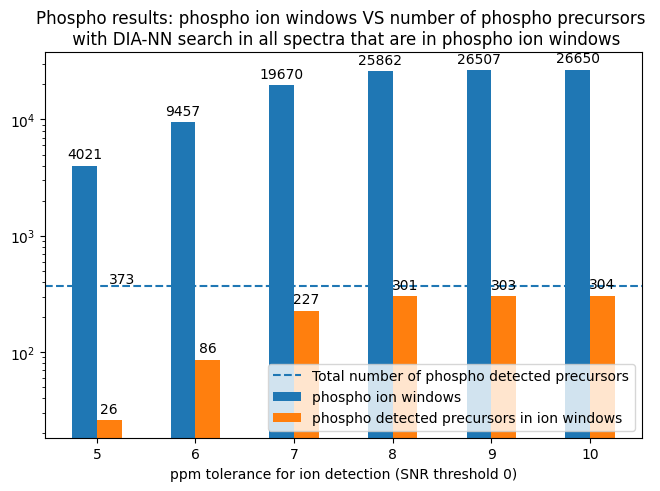

In [17]:
phospho_ion_windows_per_ppm = []
phospho_precursors_in_ion_windows_per_ppm = []
ppms = np.array([5, 6, 7, 8, 9, 10])
for ppm in ppms:
    df_ppm = pd.read_csv(f"../../data/result_csvs/230928_JL_Immonium_ions_Modified_DIA.mzML_diagnostic_ions_ppm_tolerance_{ppm}_snr_threshold_0.csv")
    phospho_detected_ppm = get_detected_ions_for_mod(df_ppm, "Tyrosine", "Phospho")
    detected_ids_phopspho_ppm = phospho_detected_ppm["id_numbers"]
    in_phospho_detected_all_ppm = set(phospho_precursors_all["higher_energy_ids"].to_numpy()).intersection(set(detected_ids_phopspho_ppm))
    phospho_ion_windows_per_ppm.append(len(phospho_detected_ppm))
    phospho_precursors_in_ion_windows_per_ppm.append(len(in_phospho_detected_all_ppm))

width = 0.25
fig, ax = plt.subplots(layout='constrained')

ax.bar_label(ax.bar(ppms, phospho_ion_windows_per_ppm, width, label="phospho ion windows"), padding=3)

ax.bar_label(ax.bar(ppms + width, phospho_precursors_in_ion_windows_per_ppm, width, label=f"phospho detected precursors in ion windows"), padding=3)
ax.axhline(len(phospho_precursors_all), label="Total number of phospho detected precursors", linestyle="dashed")
ax.text(ppms[0] + width, len(phospho_precursors_all) + 20, len(phospho_precursors_all))

ax.set_xlabel("ppm tolerance for ion detection (SNR threshold 0)")
ax.set_title("Phospho results: phospho ion windows VS number of phospho precursors \n with DIA-NN search in all spectra that are in phospho ion windows")
plt.legend(loc="lower right")
ax.set_xticks(ppms + width/2, ppms)
ax.set_yscale("log")
plt.savefig("../../data/plots/phospho_results_all_spectra.png")
plt.show()

In [16]:
len(not_in_phospho_detected_all)

70

In [17]:
len(in_phospho_detected_all)

303

In [22]:
od_exp = OnDiscMSExperiment()

od_exp.openFile("../../data/230928_JL_Immonium_ions_Modified_DIA.mzML")

True

In [18]:
exp2 = MSExperiment()

MzMLFile().load("../../data/230928_JL_Immonium_ions_Modified_DIA.mzML", exp2)
spectra_all2 = exp2.getSpectra()

In [19]:
tolerance_margin = 216.042 * 10 / 1e6
print(216.042 - tolerance_margin, 216.042 + tolerance_margin)

216.03983958 216.04416042


In [20]:
def ion_detection(spectrum):
    spectrum_mz, intensities = spectrum.get_peaks()
    lower_border = np.searchsorted(spectrum_mz, 216.042 - tolerance_margin, side="left")
    higher_border = np.searchsorted(spectrum_mz, 216.042 + tolerance_margin, side="right")

    detected_peaks_mz = spectrum_mz[lower_border:higher_border]
    detected_peaks_intensities = intensities[lower_border:higher_border]
    if len(detected_peaks_mz) == 0:
        return None, 0
    max_peak_idx = np.argmax(detected_peaks_intensities)
    max_peak_mz = detected_peaks_mz[max_peak_idx]
    max_peak_intensity = detected_peaks_intensities[max_peak_idx]
    return max_peak_mz, max_peak_intensity

In [28]:
plt.close()

None found for 63363
Empty DataFrame
Columns: [spectrum_id, amino_acid, mod_name, letter_and_unimod_format_mod, type, theoretical_mz, detected_mz, detected_intensity]
Index: []
69126 5688.262 3048.393
None found for 68617
Empty DataFrame
Columns: [spectrum_id, amino_acid, mod_name, letter_and_unimod_format_mod, type, theoretical_mz, detected_mz, detected_intensity]
Index: []
62477 11830.198 6397.723
68749 42949.668 31397.877
70797 22528.607 14616.979
None found for 84240
Empty DataFrame
Columns: [spectrum_id, amino_acid, mod_name, letter_and_unimod_format_mod, type, theoretical_mz, detected_mz, detected_intensity]
Index: []
None found for 76942
Empty DataFrame
Columns: [spectrum_id, amino_acid, mod_name, letter_and_unimod_format_mod, type, theoretical_mz, detected_mz, detected_intensity]
Index: []
84376 11268.652 10733.317
78618 5593.2495 3725.1455
None found for 94235
Empty DataFrame
Columns: [spectrum_id, amino_acid, mod_name, letter_and_unimod_format_mod, type, theoretical_mz, detec

/tmp/ipykernel_15602/2167782599.py:9: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  plt.figure()


75837 19690.305 12282.12
95038 7057.9395 5845.04
69699 28598.854 16626.555
None found for 44229
Empty DataFrame
Columns: [spectrum_id, amino_acid, mod_name, letter_and_unimod_format_mod, type, theoretical_mz, detected_mz, detected_intensity]
Index: []
72390 171831.27 165409.62
71751 8204.604 5461.585
70728 9283.191 4201.6177
44281 253840.0 169212.34
56266 36445.168 23823.922
70219 11788.211 9607.7295
None found for 90955
Empty DataFrame
Columns: [spectrum_id, amino_acid, mod_name, letter_and_unimod_format_mod, type, theoretical_mz, detected_mz, detected_intensity]
Index: []
50503 7881.196 7416.027
None found for 62414
Empty DataFrame
Columns: [spectrum_id, amino_acid, mod_name, letter_and_unimod_format_mod, type, theoretical_mz, detected_mz, detected_intensity]
Index: []
None found for 33359
Empty DataFrame
Columns: [spectrum_id, amino_acid, mod_name, letter_and_unimod_format_mod, type, theoretical_mz, detected_mz, detected_intensity]
Index: []
54602 4736.2827 3755.8992
80210 59171.594

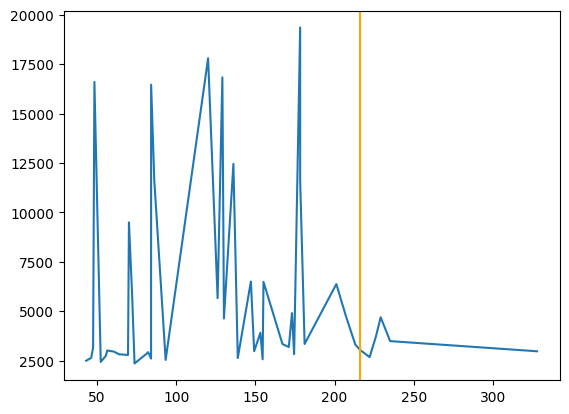

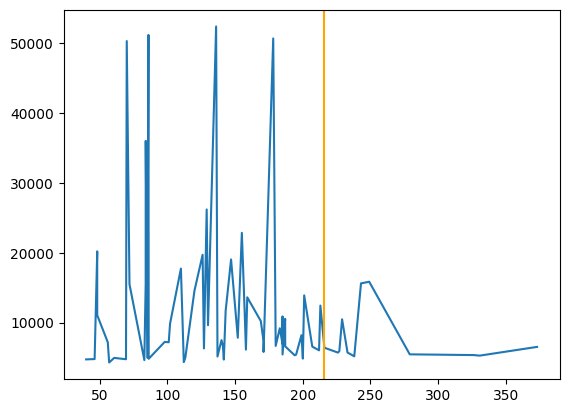

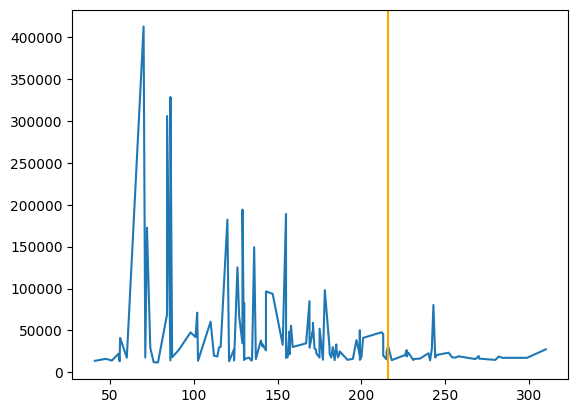

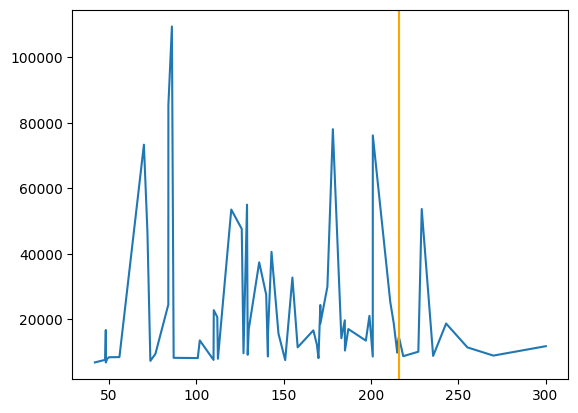

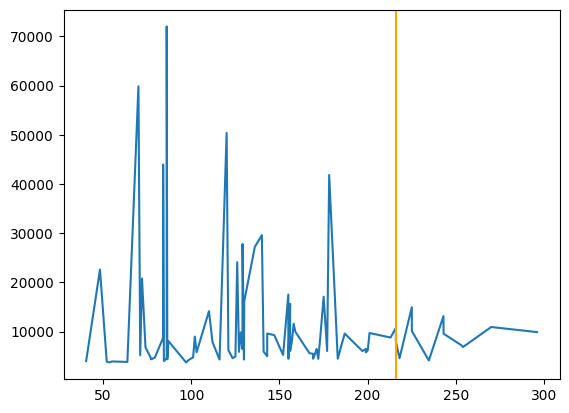

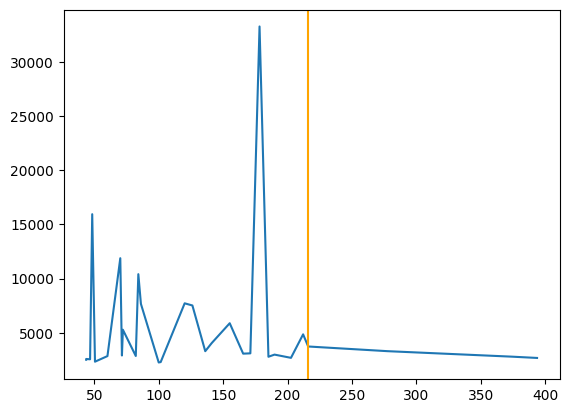

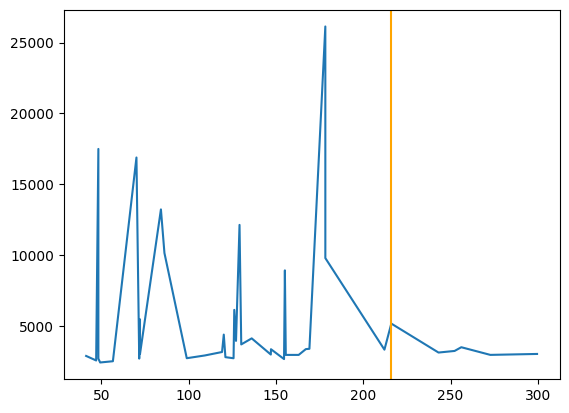

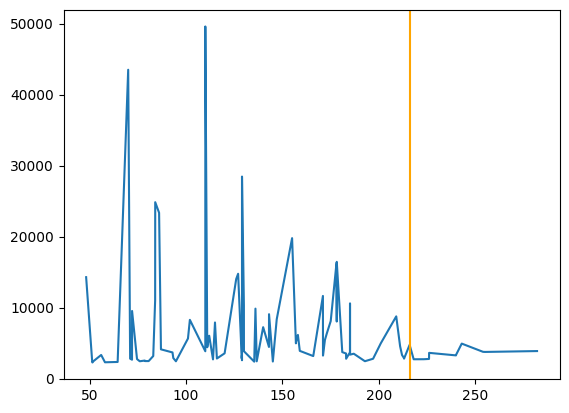

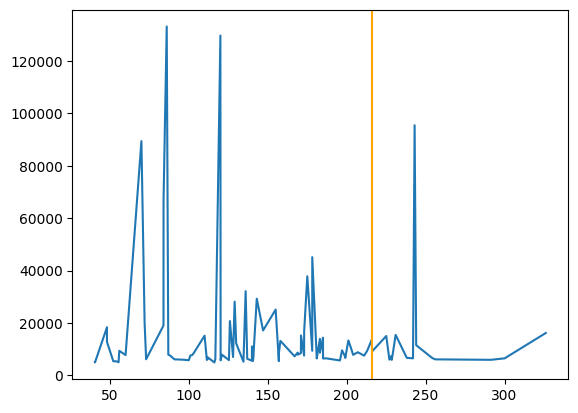

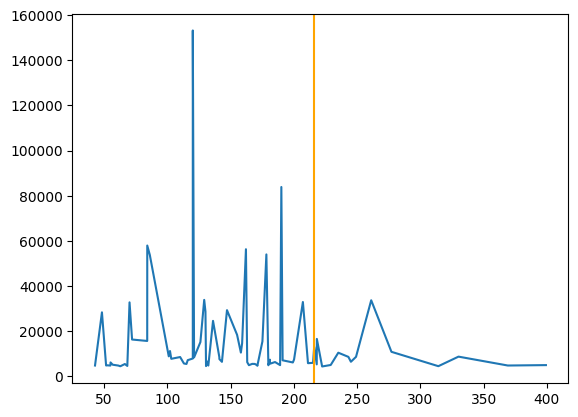

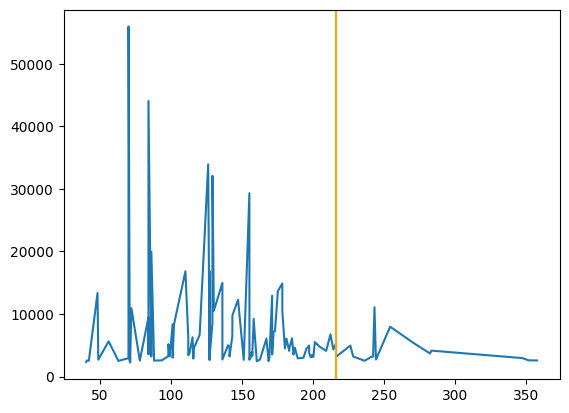

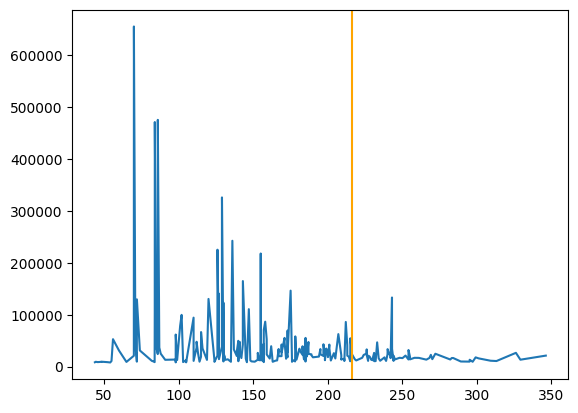

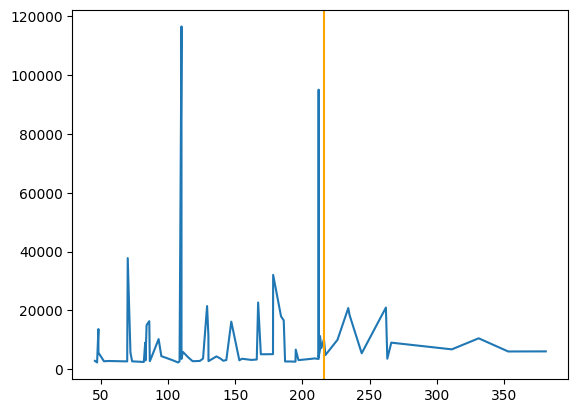

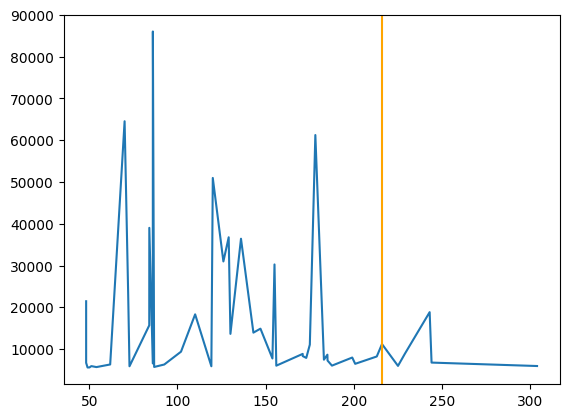

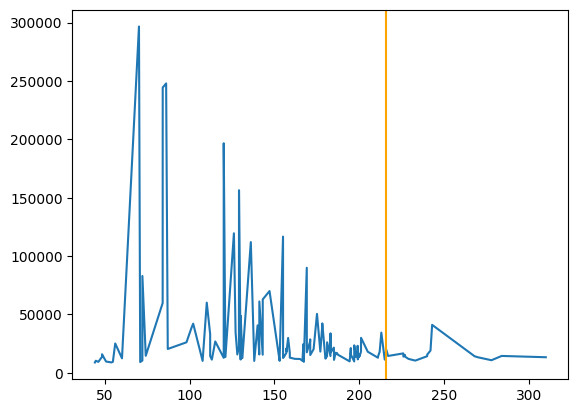

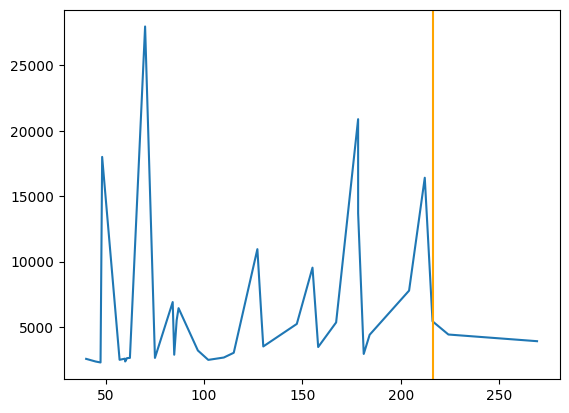

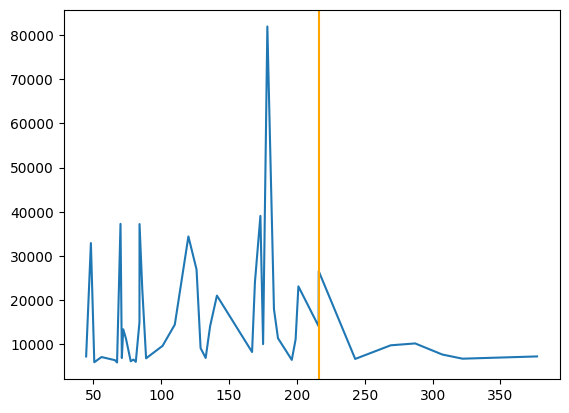

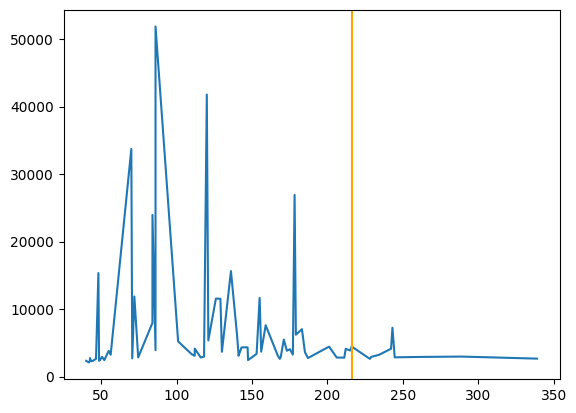

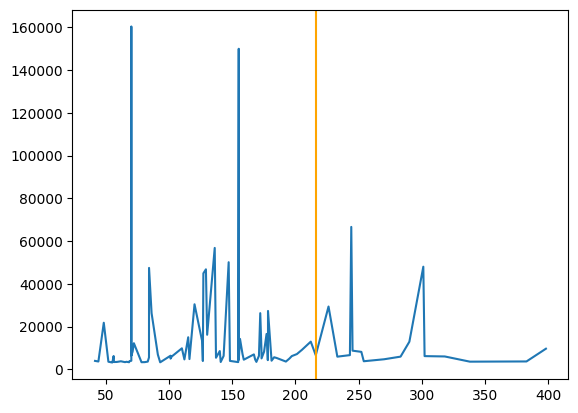

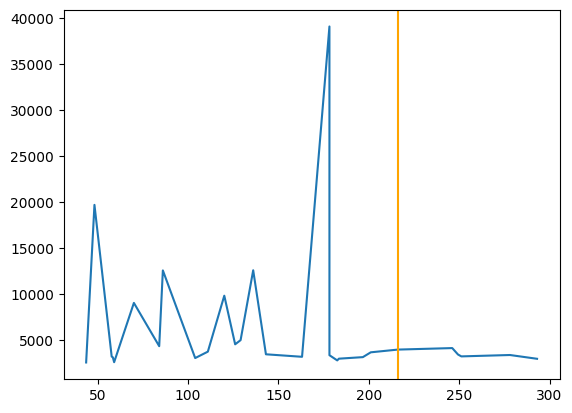

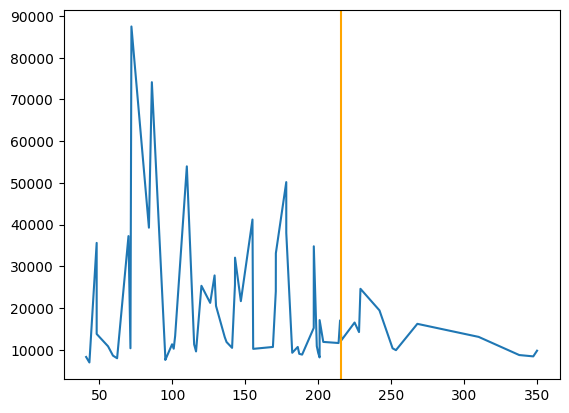

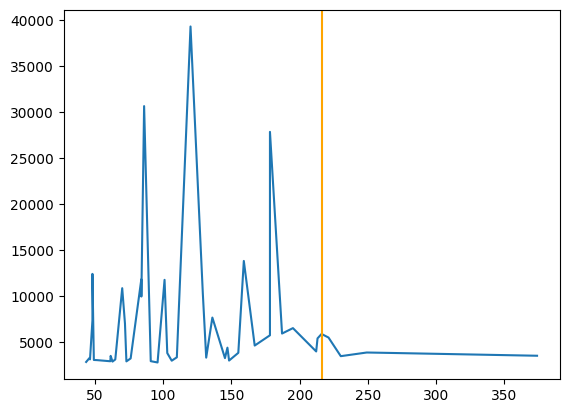

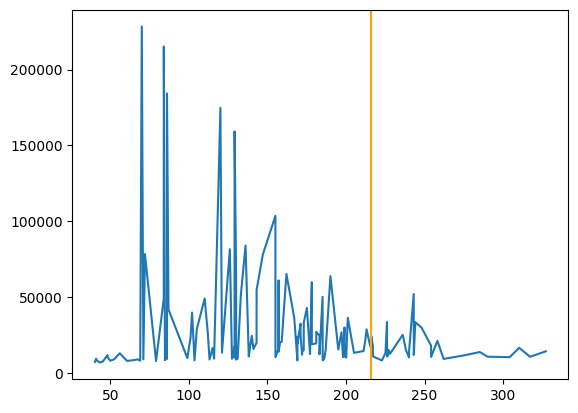

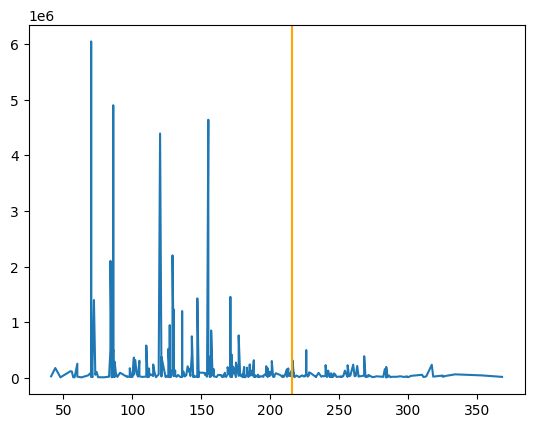

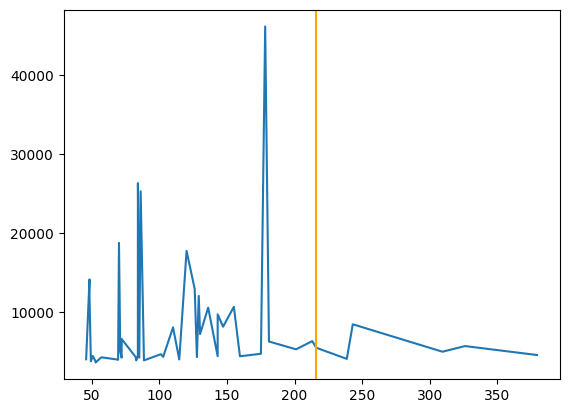

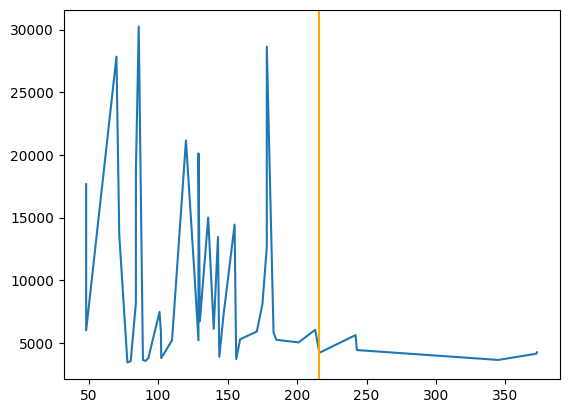

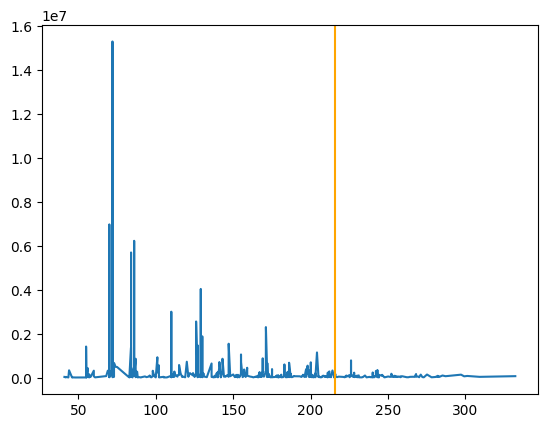

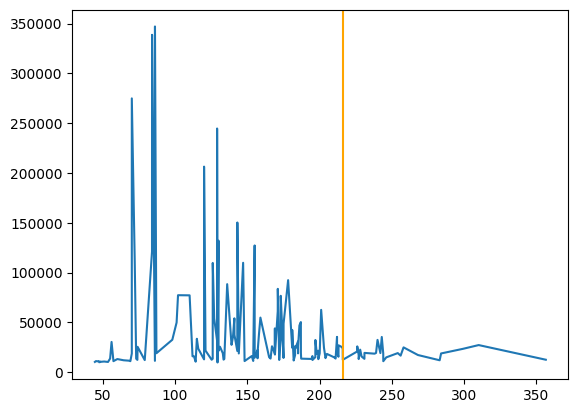

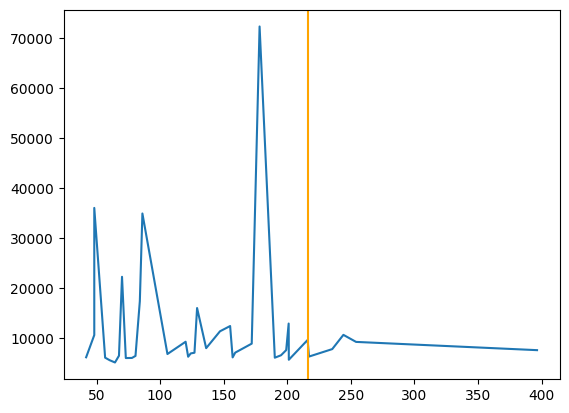

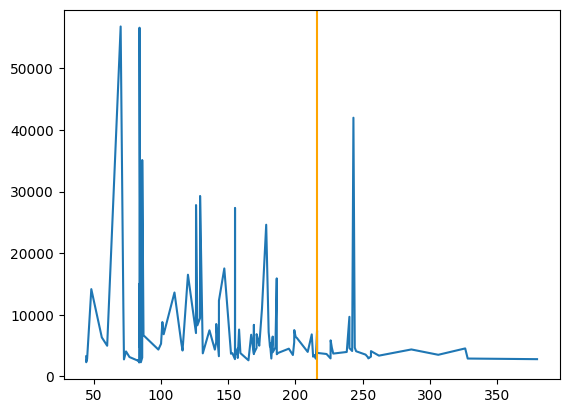

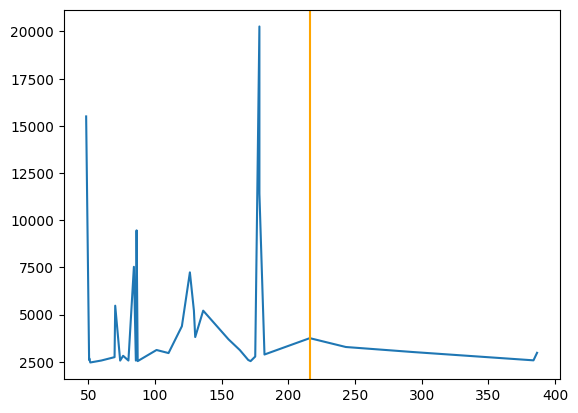

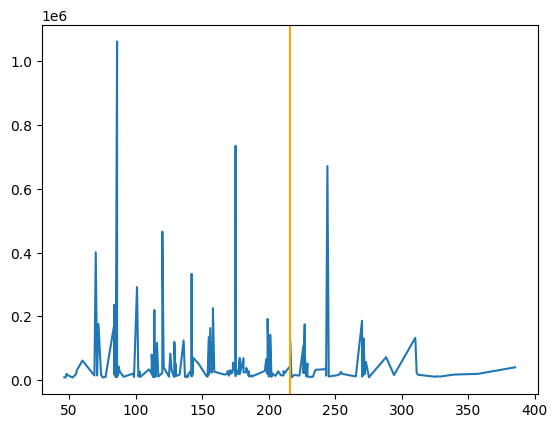

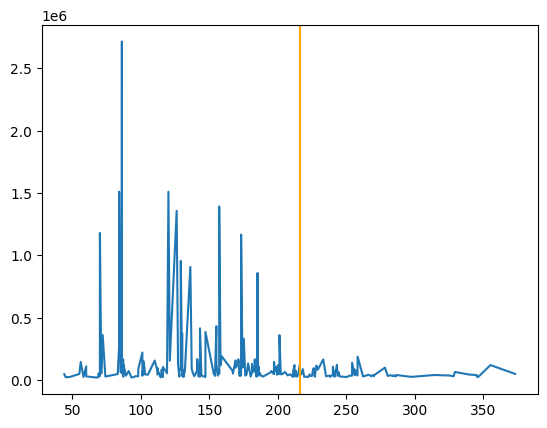

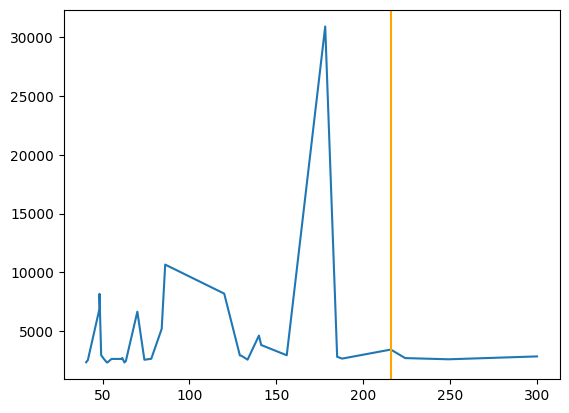

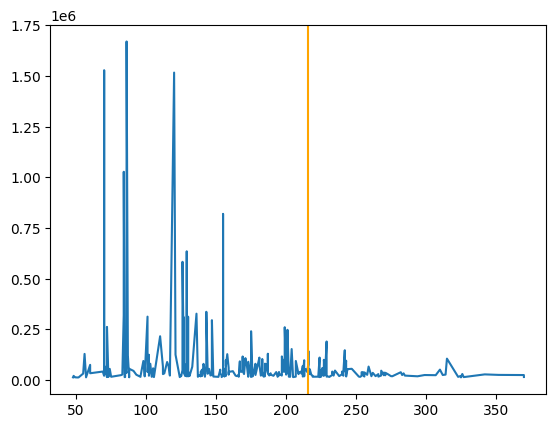

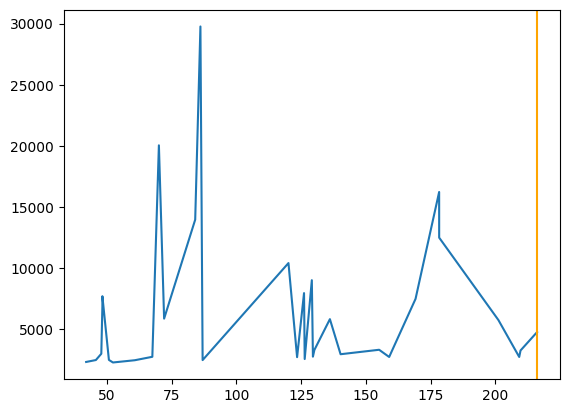

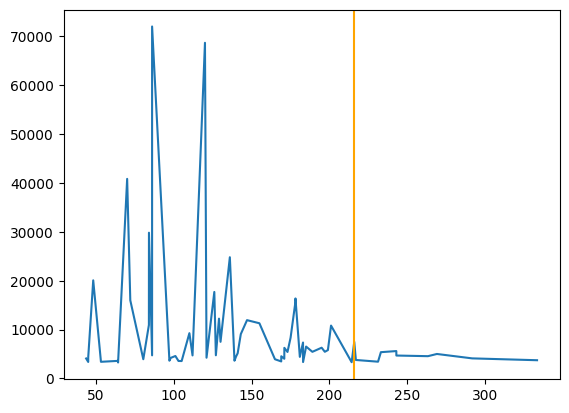

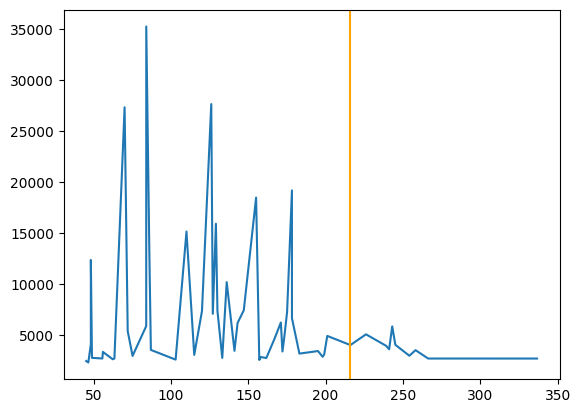

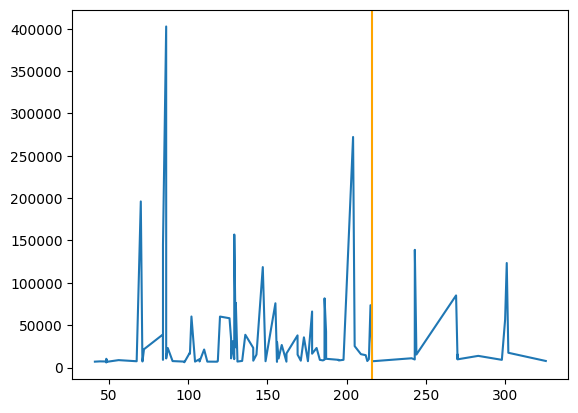

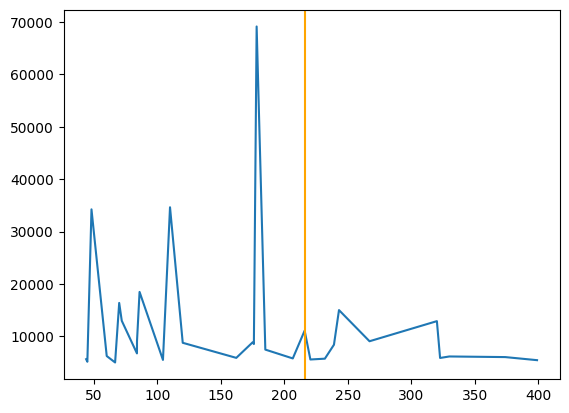

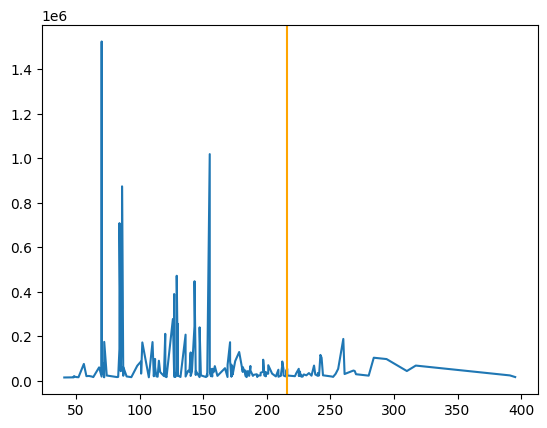

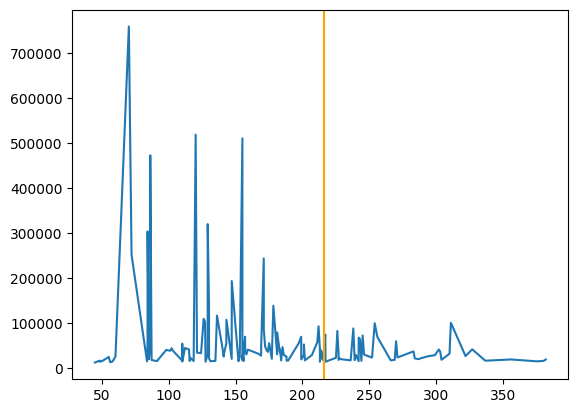

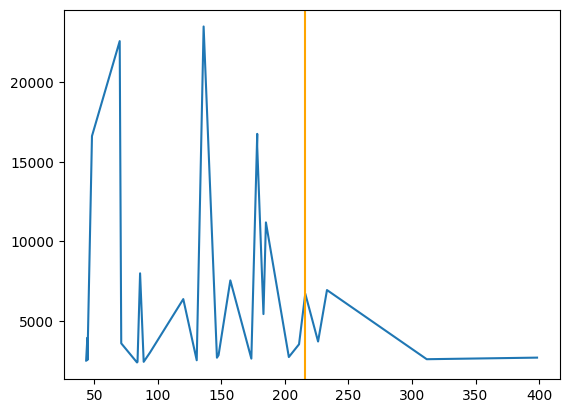

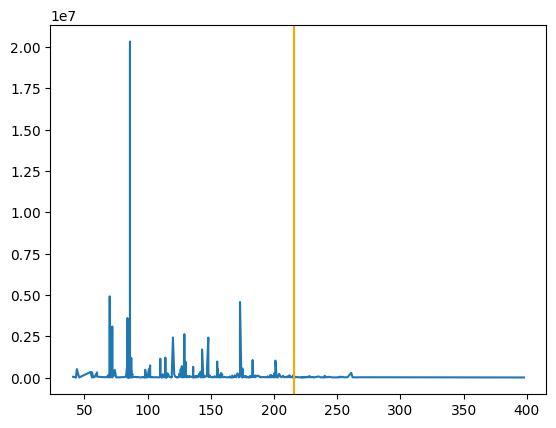

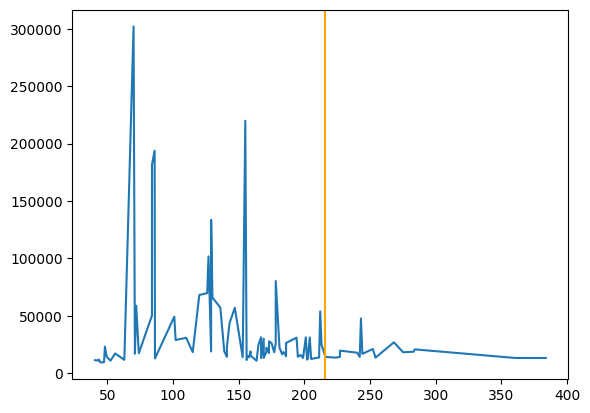

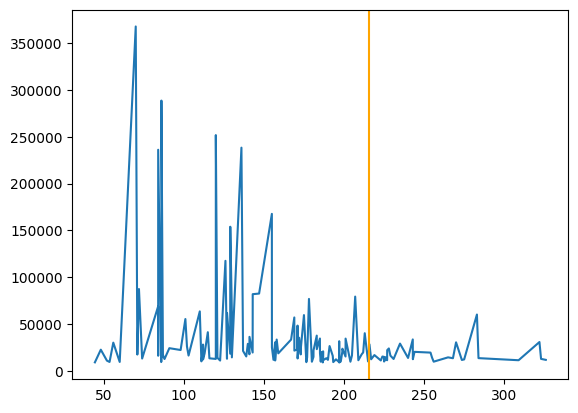

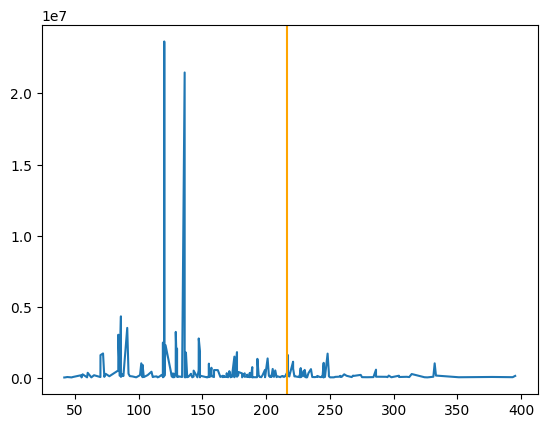

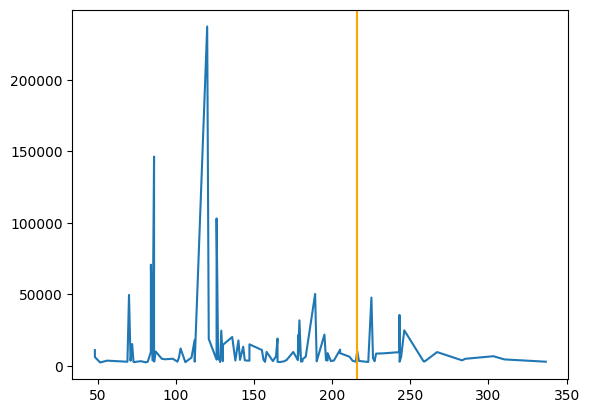

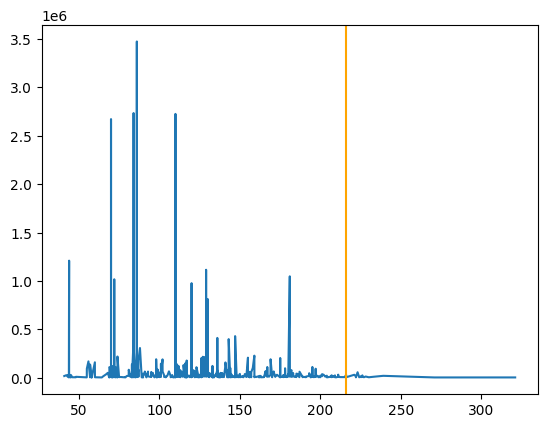

In [27]:
for id_number in not_in_phospho_detected_all:
    s = od_exp.getSpectrumByNativeId(f"controllerType=0 controllerNumber=1 scan={id_number}")
    max_peak_mz, max_peak_intensity = ion_detection(s)
    if max_peak_mz is None:
        print(f"None found for {id_number}")
        print(detected_ions_df[detected_ions_df["spectrum_id"] == s.getNativeID()])
        continue
    if max_peak_intensity < s.get_peaks()[1].mean():
        plt.figure()
        plt.plot(s.get_peaks()[0], s.get_peaks()[1])
        plt.axvline(max_peak_mz, color="orange")
        print(id_number, s.get_peaks()[1].mean(), max_peak_intensity)
    else: print(id_number, max_peak_intensity < s.get_peaks()[1].mean())

In [39]:
def plot_phospho_ions_behaviour_for_spectrum_id_within_ms1_window(s_id_number):
    current_ms1_intensities = []
    previous_ms1_intensities = []
    spectrum_idcs = []
    phospho_precursor_idcs = []

    initial_spectrum_idx = [i[0] for i in enumerate(spectra_all2) if i[1].getNativeID() == f"controllerType=0 controllerNumber=1 scan={s_id_number}"][0]
    ms1_spectrum_idx = exp2.getPrecursorSpectrum(initial_spectrum_idx)
    spectrum_idx = ms1_spectrum_idx + 1

    current_spectrum = spectra_all2[spectrum_idx]
    while current_spectrum.getMSLevel() == 2:
        if current_spectrum.getPrecursors()[0].getMetaValue("collision energy") == 50:
            current_ms1_intensity = ion_detection(current_spectrum)[1]
            previous_ms1_intensity = ion_detection(spectra_all2[spectrum_idx - 73])[1]
            current_ms1_intensities.append(current_ms1_intensity)
            previous_ms1_intensities.append(previous_ms1_intensity)
            spectrum_idcs.append(spectrum_idx)
            if get_id_number(current_spectrum.getNativeID()) in phospho_precursors_all["higher_energy_ids"].to_numpy():
                phospho_precursor_idcs.append(spectrum_idx)

        spectrum_idx += 1
        current_spectrum = spectra_all2[spectrum_idx]

    plt.figure(figsize=(6, 4))
    plt.plot(spectrum_idcs, previous_ms1_intensities, label="immonium ions in windows for previous MS1 window", marker="o", color="orange")
    plt.plot(spectrum_idcs, current_ms1_intensities, label="immonium ions in windows for current MS1 window", marker="o")
    
    for precursor_idx in phospho_precursor_idcs:
        color = "g" if get_id_number(spectra_all2[precursor_idx].getNativeID()) in in_phospho_detected_all else "r"
        plt.axvline(precursor_idx, color=color)
    #plt.axvline(initial_spectrum_idx, color="violet")
    plt.legend(loc="upper right")


In [23]:
def plot_phospho_ions_behaviour_for_spectrum_id_within_mz_range(s_id_number):
    intensities = []
    spectrum_idcs = []
    phospho_precursor_idcs = []

    initial_spectrum_idx = [i[0] for i in enumerate(spectra_all2) if i[1].getNativeID() == f"controllerType=0 controllerNumber=1 scan={s_id_number}"][0]
    spectrum_idx = initial_spectrum_idx % 73

    while spectrum_idx < len(spectra_all2):
        current_spectrum = spectra_all2[spectrum_idx]
        
        intensity = ion_detection(current_spectrum)[1]
        intensities.append(intensity)
        spectrum_idcs.append(spectrum_idx)
        if get_id_number(current_spectrum.getNativeID()) in phospho_precursors_all["higher_energy_ids"].to_numpy():
            phospho_precursor_idcs.append(spectrum_idx)

        spectrum_idx += 73

    plt.figure(figsize=((16, 5)))
    plt.plot(spectrum_idcs, intensities)
    
    for precursor_idx in phospho_precursor_idcs:
        color = "g" if get_id_number(spectra_all2[precursor_idx].getNativeID()) in in_phospho_detected_all else "r"
        plt.axvline(precursor_idx, color=color)

    print([get_id_number(spectra_all2[precursor_idx].getNativeID()) for precursor_idx in phospho_precursor_idcs])

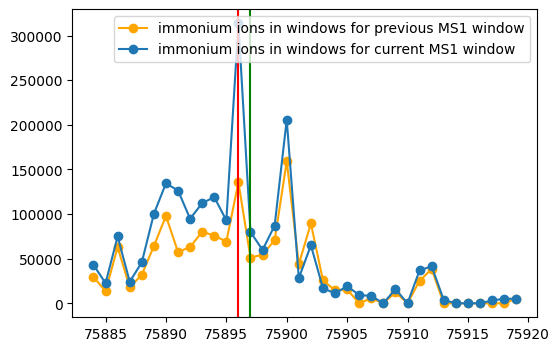

In [55]:
plot_phospho_ions_behaviour_for_spectrum_id_within_ms1_window(75897)

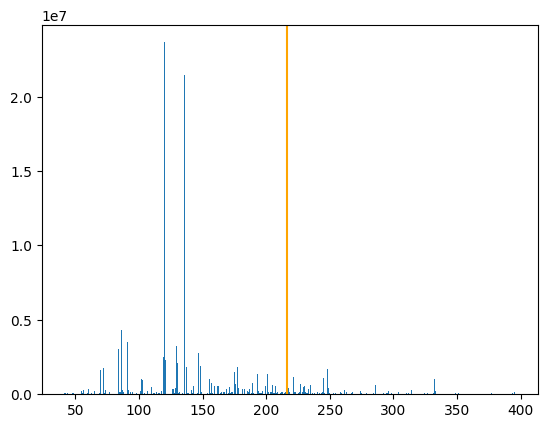

In [38]:
plt.bar(*od_exp.getSpectrumByNativeId("controllerType=0 controllerNumber=1 scan=75897").get_peaks())
plt.axvline(216.042, color="orange")

In [30]:
detected_ions_df[detected_ions_df["spectrum_id"] == "controllerType=0 controllerNumber=1 scan=75897"]

,spectrum_id,amino_acid,mod_name,type,theoretical_mz,detected_mz,detected_intensity
283832,controllerType=0 controllerNumber=1 scan=75897,Arginine,unmodified,IM-59,70.0651,70.064606,1621460.90
283833,controllerType=0 controllerNumber=1 scan=75897,Lysine,unmodified,IM-NH3,84.0808,84.080124,3055120.80
283834,controllerType=0 controllerNumber=1 scan=75897,Lysine,unmodified,alpha-amino-epsilon-caprolactam,129.1022,129.101196,3252772.50
283835,controllerType=0 controllerNumber=1 scan=75897,Lysine,Acetyl,IM,143.1179,143.116684,535526.44
283836,controllerType=0 controllerNumber=1 scan=75897,Proline,unmodified,IM,70.0651,70.064606,1621460.90
283837,controllerType=0 controllerNumber=1 scan=75897,Tyrosine,unmodified,IM,136.0757,136.074509,21465948.00


[26695, 28666, 31075, 34944, 35820, 44215, 49544, 50347, 51807, 51880, 56698, 56771, 68597, 70787, 75897]


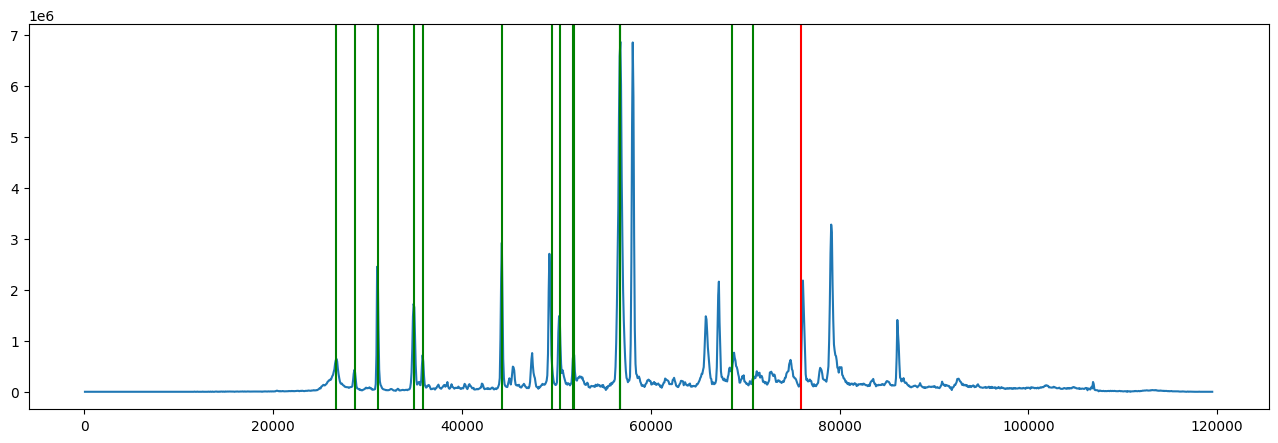

In [200]:
plot_phospho_ions_behaviour_for_spectrum_id_within_mz_range(75897)

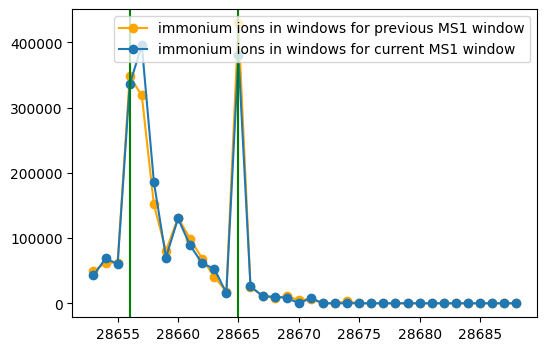

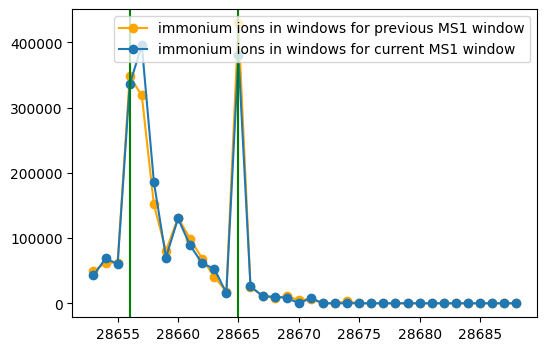

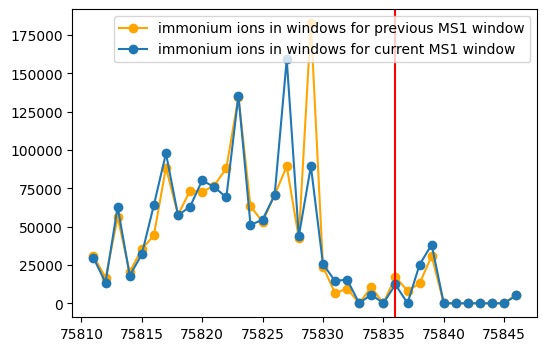

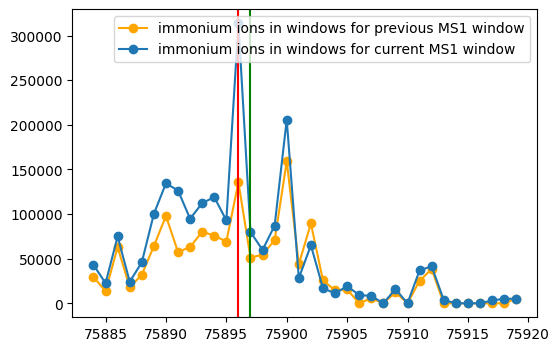

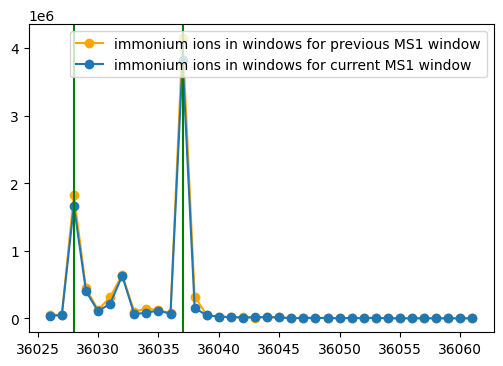

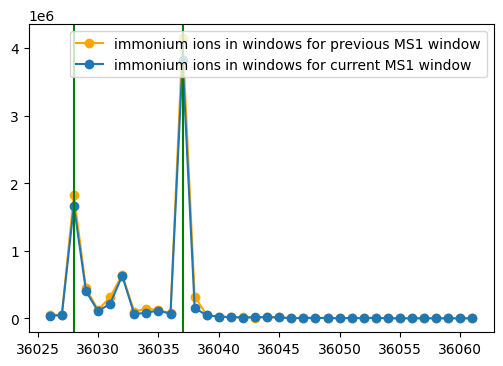

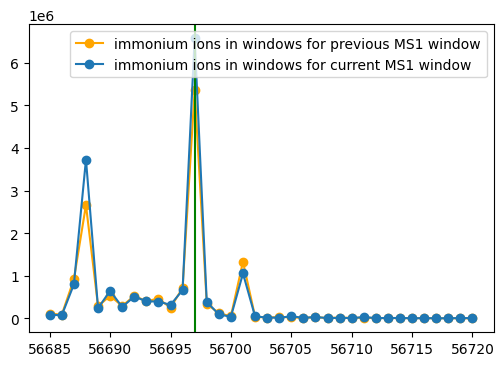

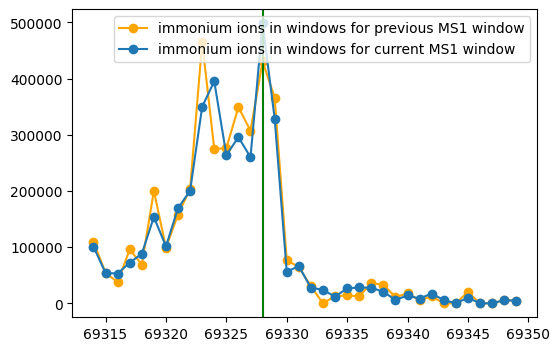

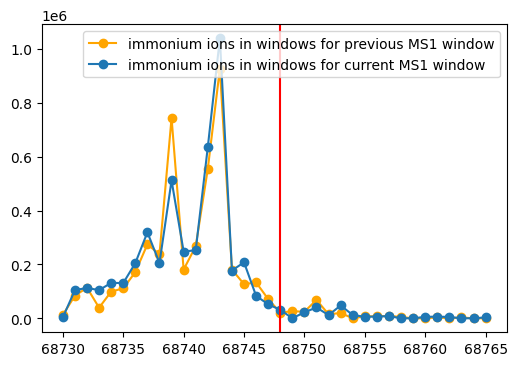

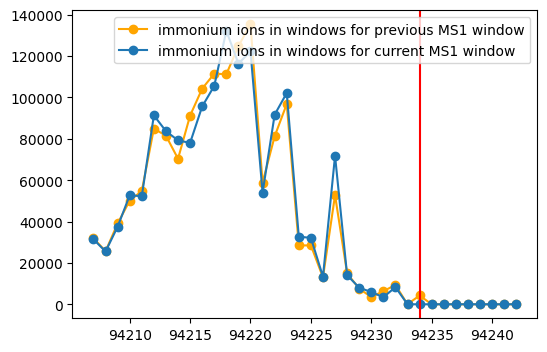

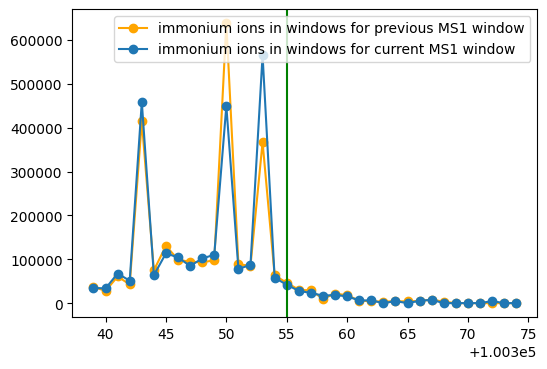

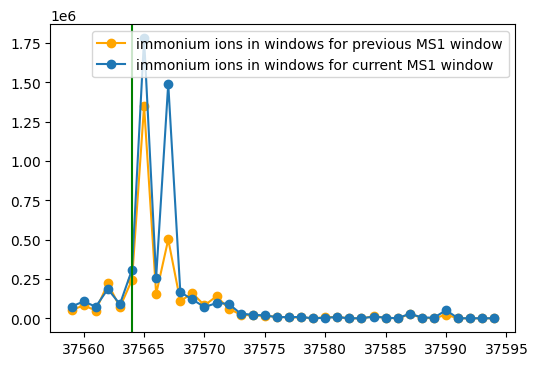

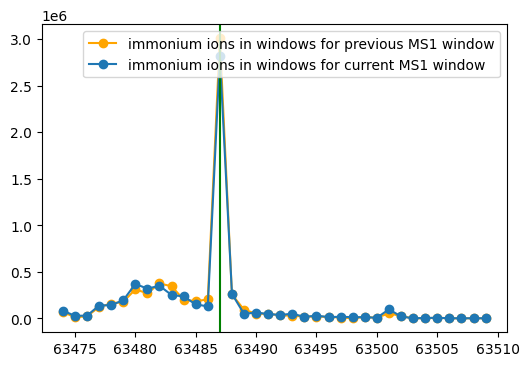

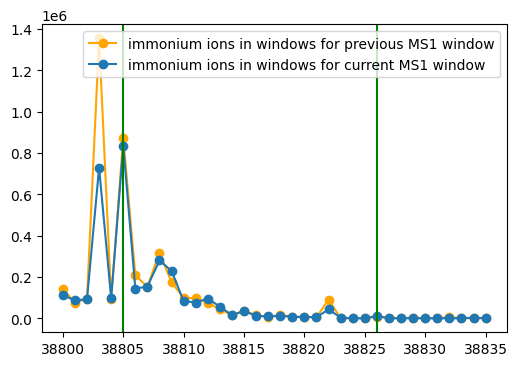

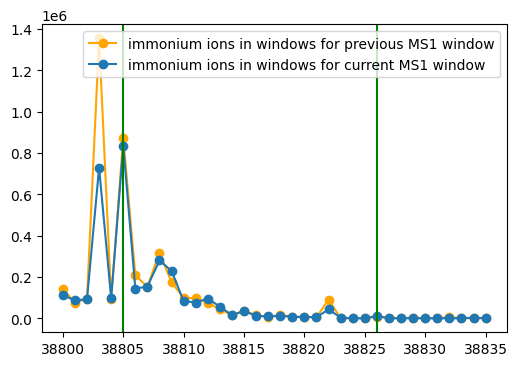

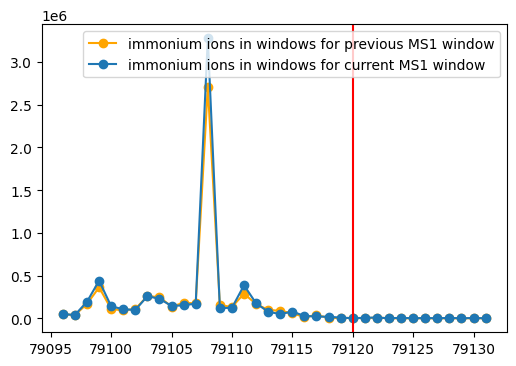

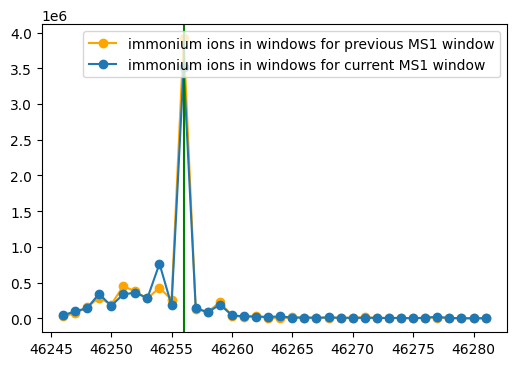

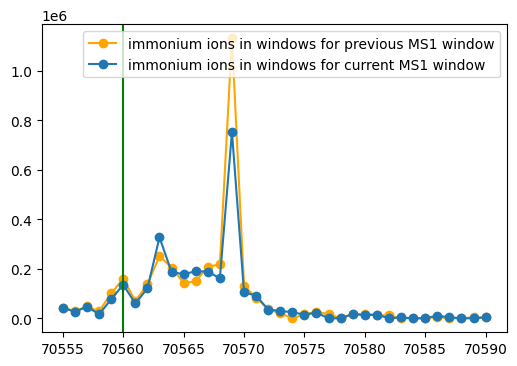

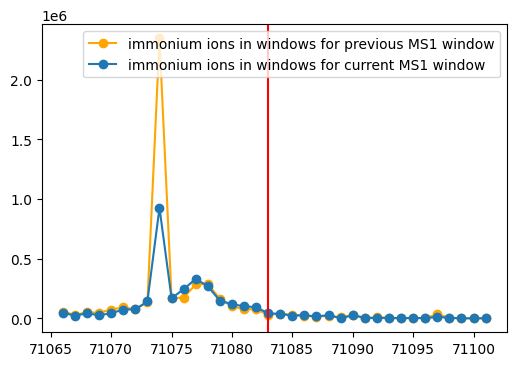

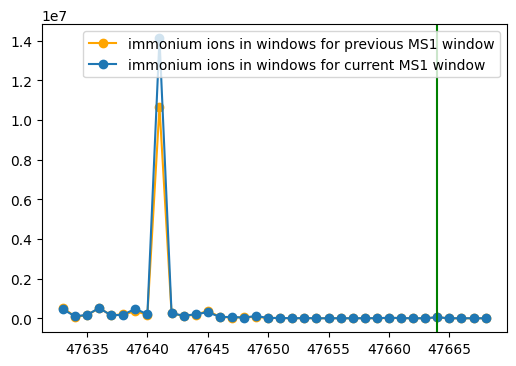

In [56]:
for id in phospho_precursors_all["higher_energy_ids"].to_numpy()[:20]:
    plot_phospho_ions_behaviour_for_spectrum_id_within_ms1_window(id)

In [57]:
plt.close()